# Summary statistics and sbi methods

We have seen that, for the `sbi` workflow, we need a simulator that generates data $x$ given a certain $\theta$, and that we can sample randomly the prior distribution of $\theta$ so as to generate a large dataset of $x_i$ values. Then, we trained a neural neutwork (for example a normalizing flow) to estimate the conditional posterior distribution $P(\theta_i|x_i)$ by feeding it the data $x_i$ and trying to predict the correct $\theta_i$.

Many times, the output $x$ of a simulator might be of very high dimension. Such are the cases of simulators that generate RGB images, or trajectories as a function of time. Training a neural network to learn the conditional posterior distribution of the parameters given these high-dimensional data might be difficult or even impossible to implement in some cases.  

In this notebook we will explore the possibility of learning conditional probabilities of the parameters from certain estimators of the data that we will call *summary statistics*.

## Molecular Dynamics simulator


In this example, we will be working with a one-dimensional molecular dynamics simulator. Our simulator consists of four Argon atoms that interact between each other by means of forces goverened by some potential function. One of the simplest potential descriptions is that of [Lennard-Jones](https://es.wikipedia.org/wiki/Potencial_de_Lennard-Jones), which consists in two terms, an attractive and a repulsive one as follows

$$
V(r) = 4 \epsilon\left[\left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6\right].
$$

If we consider the force ar the negative gradient (derivative with respect to the position) of the potential energy, then we can write
$$
\|\vec{F}(r)\| = 48 \epsilon  \sigma^{12} / r^{13} - 24  \epsilon  \sigma^{6}/r^7,
$$
where the direction has been omitted, but is along the line connecting both interacting particles. Since we have an analytical description for the force, it is now possible to use [Newton's laws of motion](https://en.wikipedia.org/wiki/Newton%27s_laws_of_motion) to get the acceleration, velocity, and position of each particle at any given time for a given set of initial conditions. A simulator that solves Newton's equations is provided in the [./simulators/md.py](./simulators/md.py) module. If you are interested in the details, feel free to look at the source code, it is a slightly modified version of an implementation that can be found in [Python Chemistry](https://pythoninchemistry.org/sim_and_scat/molecular_dynamics/build_an_md).


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

import pickle
from scipy.signal import find_peaks
import os

# sbi related
import sbi.utils as utils
from sbi.inference import SNPE, simulate_for_sbi
from sbi.analysis import pairplot
from sbi.neural_nets import posterior_nn
from sbi.utils.user_input_checks import (
    process_prior,
    process_simulator,
) 
from sbi.utils.sbiutils import seed_all_backends

# We borrow this function from the cell growth example 
from simulators.cell_growth import FlexibleBoxUniform

# Bring the molecular dynamixs 1D simulator
from simulators.md import run_md

num_cpus = os.cpu_count()
workers = num_cpus - 1
print(f"Found {num_cpus} cores. Will use {workers}.")
seed_all_backends(24)

Found 256 cores. Will use 255.


Let's see which are the inputs and outputs of our simulator:

In [2]:
run_md?

Signature:
run_md(
    dt,
    number_of_steps,
    x,
    initial_temp,
    epsilon,
    sigma,
    box_length=20,
    seed=None,
)
Docstring:
Run a molecular dynamics (MD) simulation using the velocity Verlet algorithm.

Parameters
----------
dt : float
    The timestep length (s).
number_of_steps : int
    Number of iterations in the simulation.
x : ndarray of floats
    The initial positions of the particles in a single dimension (Å).
initial_temp : float
    Temperature of the system at initialization (K).
epsilon : float
    Depth of the potential well in the Lennard-Jones potential (energy units).
sigma : float
    Finite distance at which the inter-particle potential is zero (Å).
box_length : float, optional, default=20
    Length of the simulation box (Å).
seed : int, optional, default=None
    Random seed for reproducibility.

Returns
-------
positions : ndarray of floats
    The positions of all particles at each timestep of the simulation (Å).
    Shape: (number_of_steps, n

A simulation is completely determined once both the Lennard-Jones potential parameters $\epsilon$ and $\sigma$, the initial positions $\vec{x_0}$ of all the atoms, as well as the Temperature of the system are defined. A timestep must be provided for the time resolution.

#### Observed data
Now, let's suppose we observed (measured) the trajectories of 4 atoms in a box of length 20 m for 800 seconds. Let's load the measured data and see it

In [3]:
with open("../data/observation_free.pkl", "rb") as pf:
    t, x_truth = pickle.load(pf)

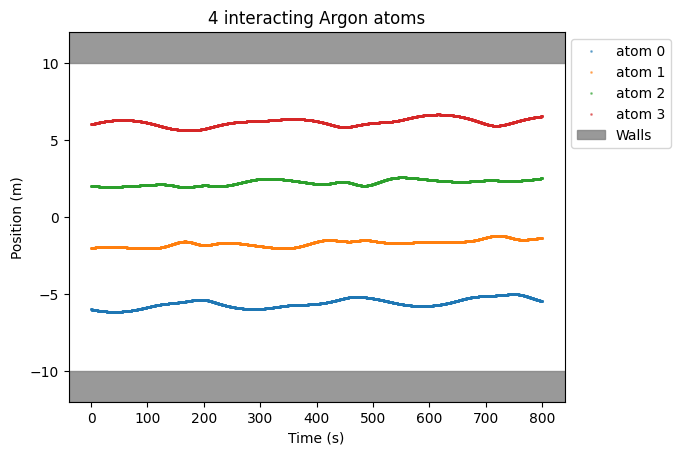

In [4]:
# we know the length of our box
box_length = 20

# plot the measured data
for i in range(0, x_truth.shape[1]):
    plt.plot(t, x_truth[:, i], 'o', ms=1, label=f"atom {i}", alpha=0.5)
plt.ylim(-box_length * 0.6, box_length * 0.6)
plt.axhspan(box_length/2, plt.ylim()[1], color='gray', alpha=0.8, label="Walls")
plt.axhspan(plt.ylim()[0], -box_length/2, color='gray', alpha=0.8)
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("4 interacting Argon atoms")
plt.show()

The trajectories are informative of the potential that the particles feel. Since the initial positions are a measured quantity, we can take them as fixed parameters. What we don't know about this system is the potential energy parameters that would model these trajectories adequately, as well as the temperature of the system. You can play around with these parameters in our molecular dynamics simulator so that you can get a feeling of the role of these parameters, and reasonable *limits* for them.

In [5]:
# get initial positions
x0 = x_truth[0, :]

# get timestep
dt = t[1] - t[0]

Remember, temperatures are in Kelvin (300K is room temperature), $\epsilon$ and $\sigma$ are in angstroms, and are in the order of atomic distances.

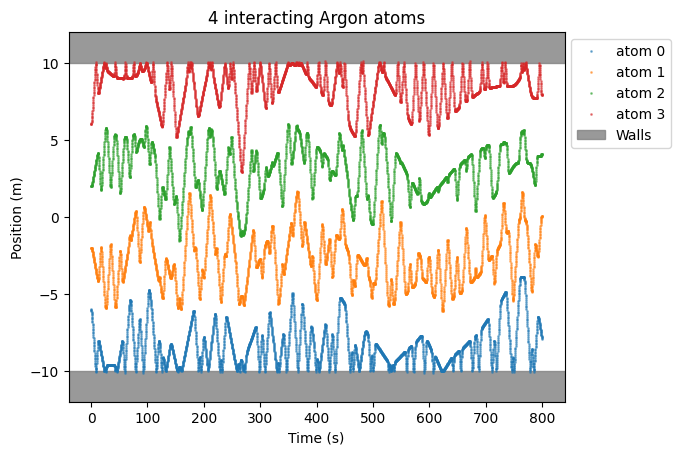

In [6]:
def create_x(theta):
        T, epsilon, sigma = theta.numpy()
        return run_md(dt, len(t), x0, T, epsilon, sigma, box_length=box_length)

def plot_single(theta):
    x = create_x(theta)
    for i in range(0, x_truth.shape[1]):
        plt.plot(t, x[:, i], 'o', ms=1, label=f"atom {i}", alpha=0.5)
    plt.ylim(-box_length * 0.6, box_length * 0.6)
    plt.axhspan(box_length/2, plt.ylim()[1], color='gray', alpha=0.8, label="Walls")
    plt.axhspan(plt.ylim()[0], -box_length/2, color='gray', alpha=0.8)
    plt.legend(bbox_to_anchor=(1,1))
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("4 interacting Argon atoms")
    plt.show()

T = 100 # Kelvin
epsilon = 0.1 # eV/Angstrom
sigma = 5 # angstrom

theta_test = torch.tensor([T, epsilon, sigma])
plot_single(theta_test)

### Introduction to summary statistics

If we are to follow up on the `sbi` workflow that we have seen previously, you might wonder how are we going to feed this type of data into our neural network for posterior distribution estimation. If we were to feed the whole trajectories as input, this would imply large input spaces, therefore larger networks to train and many times this would not even be feasible. A way to overcome this is to introduce summary statistics that, as their name indicate, summarize the information into fewer representative quantities.

If we think about this specific problem, you might get a feeling by inspecting the previous plot that when the temperature is higher, the trajectories are more oscillating and have large amount of valleys and peaks. Also when the potential energy parameters vary, the particles may be allowed to get closer (or not) in space. We can therefore think on some possible summary stastics as follows:

- average pairwise distance: We can calculate the average pairwise distance between atoms, that might be informative of the potential parameters. If we have 4 atoms, there are ($4 \times 3 )/2 = 6$ pairwise distances.

- average energy: It is possible to estimate the velocity since we have positions over time, and then calculate the kinetic energy by using $0.5 m v^2$, where $m$ is the mass of the argon atoms. We can average this quantity over time and all aprticles and get 1 quantity.

- peaks and valleys: We can use the `find_peaks` function for the square of the deviations to get the number of peaks and valleys (for each atom, therefore 4 quantities).

Therefore for a given $\theta=(T,\epsilon,\sigma)$ we can obtain a vector of dimension 11 which summarizes the information of our 40000 data points.

In [7]:
def pairwise_distances(x):
    """
    Calculate pairwise distances between particles in a 2D array of positions.
    
    Args:
        x (numpy.ndarray): 2D array of positions of the particles in the simulation.
    """
    n = x.shape[1]
    i, j = np.triu_indices(n, k=1)
    distances = np.abs(x[:, i] - x[:, j])
    return distances

def calculate_average_energy(dt, x):
    """
    Calculate the average kinetic energy of a system of particles.
    
    Args:
        dt (float): Time step of the molecular dynamics simulation.
        x (numpy.ndarray): 2D array of positions of the particles in the simulation.
    
    Returns:
        float: Average kinetic energy of the system.
    """
    v = np.diff(x, axis=0)/dt # shape becomes (9999, 4)
    KE = 1./2. * np.sum(v**2, axis=1) # shape becomes (9999,)
    average_energy = np.mean(KE)
    return average_energy

def create_summary(theta):
    """
    Calculate summary statistics of a molecular dynamics simulation.
    
    Args:
        theta (numpy.ndarray): Parameter values of the molecular dynamics simulation.
    
    Returns:
        numpy.ndarray: 1D array of summary statistics, in the order of pairwise distances, number of peaks, and average kinetic energy.
    """
    T, epsilon, sigma = theta.numpy()
    x = run_md(dt, len(t), x0, T, epsilon, sigma)
    avg_pairwise_distance = pairwise_distances(x).mean(axis=0)
    num_cp = np.array(
        [len(find_peaks(i)[0]) for i in ((x - x.mean(axis=0)) ** 2).T]
    )
    average_energy = np.array([calculate_average_energy(dt, x)])
    return np.concatenate([avg_pairwise_distance, num_cp, average_energy], axis=0)

Let's test it in the test $\theta$ that we just explored

In [10]:
summary_test = create_summary(theta_test)
print(summary_test)
print(summary_test.size)

[  5.6043205   11.43526     17.0259986    5.8309395   11.4216781
   5.5907386  101.          90.          98.         106.
   0.26826371]
11


To begin the `sbi` workflow we need to define a reasonable prior, tensor-like, for each one of the 3 parameters we want to infer on. 

In [11]:
prior_min = torch.as_tensor([1e-3, 0.005, 1.6])
prior_max = torch.as_tensor([2000.0, 0.05, 5.0])
prior = FlexibleBoxUniform(
        low=prior_min, high=prior_max
    )

We can also be more general and select the device on which we are going to work according to availability

In [12]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

Then we verify and setup our simulator and prior

In [13]:
# simulate in the cpu, multiple cores
n_samples = 10000
prior.to("cpu")
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulate_x = process_simulator(create_x, prior, prior_returns_numpy)

and start the simulation for `sbi`. This might take some time, according to the resources available, and is one of the important instances during the sbi workflow where HPCs come in handy.

In [14]:
%%time
theta_traj, x_traj = simulate_for_sbi(
    simulate_x, prior, num_simulations=1000, num_workers=workers
)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 52.7 s, sys: 11.5 s, total: 1min 4s
Wall time: 3min 33s


After simulation, we can plot some of the generated trajectories for each particle. We can see that there are highly oscillating trajectories, as well as some soft ones, because the prior we chose was sufficiently uninformative on the potential parameters. 

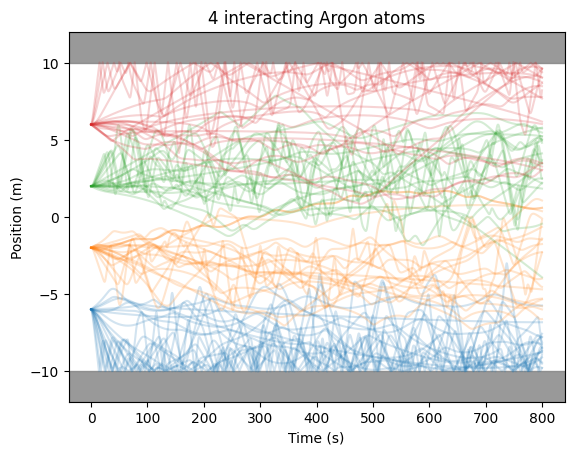

In [17]:
for i, ci in zip(range(0, x_traj.shape[2]), mcolors.TABLEAU_COLORS):
    for j in range(20):
        plt.plot(t, x_traj[np.random.choice(1000), :, i], color=ci, alpha=0.2)
plt.ylim(-box_length * 0.6, box_length * 0.6)
plt.axhspan(10, plt.ylim()[1], color='gray', alpha=0.8)
plt.axhspan(plt.ylim()[0], -10, color='gray', alpha=0.8)
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("4 interacting Argon atoms")
plt.show()

But to use `sbi` with summary statistics, we must calculate the summary statistic for each trajectory generated. One option is to use our function `create_summary` to all generated trajectories. We can also directly sample the summary statistics by passing the `create_summary` function to the `process_simulator` wrapper. Let's do it this way:

In [ ]:
simulate_summary = process_simulator(create_summary, prior, prior_returns_numpy)

In [16]:
%%time
# create summary statistics
theta, x_summary = simulate_for_sbi(
        simulate_summary, prior, num_simulations=n_samples, num_workers=workers
    )

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 1min 11s, sys: 3.04 s, total: 1min 14s
Wall time: 1min 29s


Now that we have the pairs $\theta$-summary, we can train a neural network to learn the conditional posterior distribution $P(\theta|x_{summary})$.

In [55]:
# train NN
prior.to(device)
inference = SNPE(prior=prior, device=device)
density_estimator = inference.append_simulations(theta.to(device),
                                                 x_summary.to(device),
                                                proposal=prior,
                                                exclude_invalid_x=True).train(training_batch_size=256,
                                                                              learning_rate=0.01,
                                                                              show_train_summary=True)

/p/project1/atmlaml/robledo1/ICS/sbi_intro/sbi_env/venv/lib/python3.11/site-packages/sbi/inference/trainers/npe/npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/p/project1/atmlaml/robledo1/ICS/sbi_intro/sbi_env/venv/lib/python3.11/site-packages/sbi/inference/trainers/npe/npe_base.py:157: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 117 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 117
        Best validation performance: 3.1054
        -------------------------
        


If we have GPUs available (which we do), then it is possible to bring the model back to the cpu in order to perform the inference, which is not at all costful. If we are already in the cpu, then this step does not have any effect.

In [21]:
inference._neural_net.to("cpu")
posterior = inference.build_posterior(prior=prior.to("cpu"))

We can calculate the summary statistics for the observed point, so that we sample in the vicinity of it (using the advantage of amortized inference)

In [57]:
# generate observed point summary statistics
avg_pairwise_distance = pairwise_distances(x_truth).mean(axis=0)
num_cp = np.array(
    [len(find_peaks(i)[0]) for i in ((x_truth - x_truth.mean(axis=0)) ** 2).T]
)
average_energy = [calculate_average_energy(dt, x_truth)]
x_summary_o = torch.as_tensor(np.concatenate([avg_pairwise_distance, num_cp, average_energy], axis=0))

theta_p = posterior.sample((10000,), x=x_summary_o)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Great! We now have everything to see our estimated distributions. Just to verify how the model did, we provide you the real values with which the original observed trajectories were produced:

In [58]:
# THIS IS USUALLY UNKOWN
theta_o = (600, 0.0103, 3.4)

So we can plot the result and analyze the inference capabilities of our model

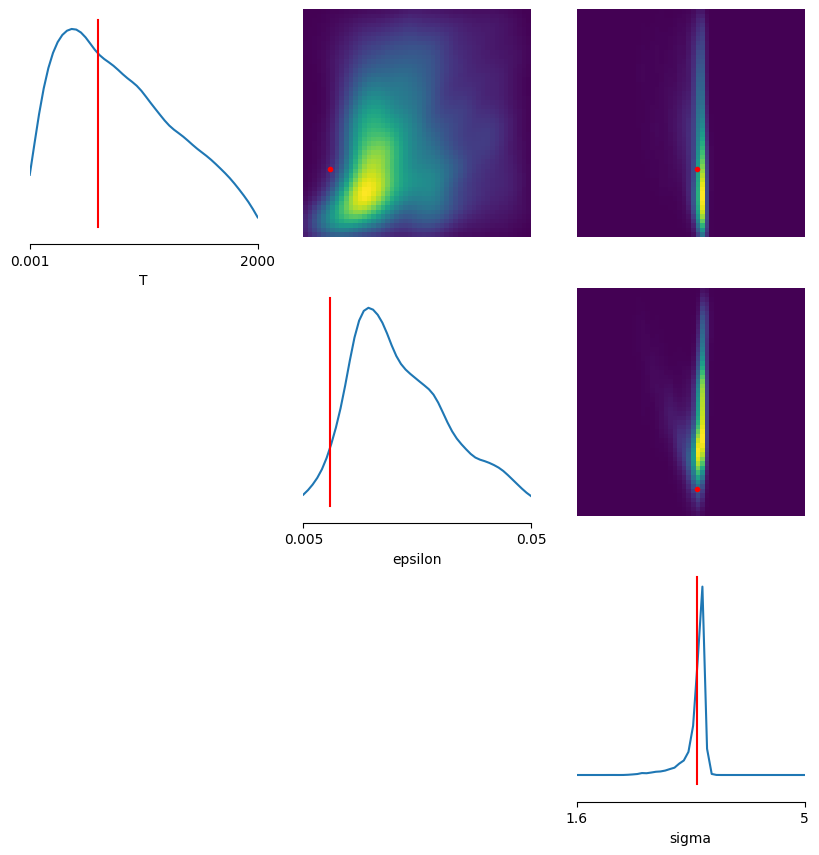

In [59]:
fig, axes = pairplot(
        theta_p,
        limits=list(zip(prior_min, prior_max)),
        ticks=list(zip(prior_min, prior_max)),
        fig_kwargs={
            "figsize": (7, 7),
            "points_offdiag": {"markersize": 6},
            "points_colors": "r",
        },
        labels=["T", "epsilon", "sigma"],
        upper="kde",
        diag="kde",
        points=theta_o,
    )
plt.show()

### Conclusion

`sbi` allowed us to infer the parameters of the Lennard-Jones potential as well as the temperature of the system from a set of summary statistics of the simulated trajectories. The summary statistics were hand-crafted to try to provide valuable insight on the actual trajectory data but at the same time reducing drastically the dimensionality of the problem. With summary statistics, SBI provides a way of putting in domain knowledge to improve the conditional posterior distribution. We could of course add more/other summary statistics to improve the estimates here, but this example has been just to showcase what can be done.  